In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Import data </h1>

Dataset: https://archive.ics.uci.edu/ml/datasets/diabetes <br>
Your goal is to use this data to develop an ML model that can predict any individual's Blood Glucose Value, given time and activity (as specified in the data description) as input. Also try to understand, and mine for any patterns for the effect of exercise on Blood Glucose.

In [2]:
# combine all data table together into one dataframe
for i in range(1,71):
    if i == 1:
        patient = "01"
        filename = 'Diabetes-Data/data-'+ patient
        rawdata = pd.read_table(filename, names = ["date", "time","code", "value" ])
        rawdata['patient'] = patient
    else:
        if i < 10 and i != 1:
            patient = "0" + str(i)
        else:
            patient = str(i)
        filename = 'Diabetes-Data/data-' + patient
        temp = pd.read_table(filename, names = ["date", "time","code", "value" ])
        temp['patient'] = patient

        rawdata = pd.concat([rawdata, temp])

data = rawdata.copy()

# change patient into an integer to save memory space and computation time
data['patient'] = pd.to_numeric(data['patient'], errors='coerce', downcast="integer")

data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29330 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29297 non-null  object
 1   time     29330 non-null  object
 2   code     29330 non-null  int64 
 3   value    29297 non-null  object
 4   patient  29330 non-null  int8  
dtypes: int64(1), int8(1), object(3)
memory usage: 1.1+ MB


In [3]:
#useful functions to calculate missing values

def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")

def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
            
#calculate missing values in the rawdata
print("Missing values")
print(missing_cols(data))
print("____")
print(perc_missing(data))

Missing values
date => 33
value => 33
None
____
date => 0.11%
value => 0.11%
None


dropping the missing values, because there are so few of them

<h1>Data cleaning </h1>

In [4]:
# remove rows with missing values
data = data.dropna()

#drop non numeric values of "value" and change value from object to float, then drop N/A values
data['value'] = pd.to_numeric(data['value'], errors='coerce')
print(missing_cols(data))
print(perc_missing(data))
print(" ")
data = data.dropna()
data['value'] = data['value'].astype(int)

print(data.info())

value => 8
None
value => 0.03%
None
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29256 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29256 non-null  object
 1   time     29256 non-null  object
 2   code     29256 non-null  int64 
 3   value    29256 non-null  int64 
 4   patient  29256 non-null  int8  
dtypes: int64(2), int8(1), object(2)
memory usage: 1.1+ MB
None


Dropping values that are not numeric, because there are so few of them

In [5]:
# create timestamp variable (timeseries) and drop invalid date formats
data['timestamp'] = pd.to_datetime(data['date'] + ' ' + data['time'], errors='coerce')
print(missing_cols(data))
print(perc_missing(data))
print(" ")
data = data.dropna()
print(data.info())

timestamp => 12
None
timestamp => 0.04%
None
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29244 entries, 0 to 340
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       29244 non-null  object        
 1   time       29244 non-null  object        
 2   code       29244 non-null  int64         
 3   value      29244 non-null  int64         
 4   patient    29244 non-null  int8          
 5   timestamp  29244 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), int8(1), object(2)
memory usage: 1.4+ MB
None


Dropping the numeric values with a wrong format, beacause there are so few of them. Mostly they are just dates where the user clearly inputted the wrong format (i.e. month and day inversed or time = 188:00)

In [6]:
# grouping the data by patient and timestamp
data = data.groupby(['patient', 'timestamp'], as_index=False).agg({"time":list, "code":list, "value":list})
data.head()

,patient,timestamp,time,code,value
0,1,1991-04-21 09:09:00,"[9:09, 9:09, 9:09]","[58, 33, 34]","[100, 9, 13]"
1,1,1991-04-21 17:08:00,"[17:08, 17:08]","[62, 33]","[119, 7]"
2,1,1991-04-21 22:51:00,[22:51],[48],[123]
3,1,1991-04-22 07:35:00,"[7:35, 7:35, 7:35]","[58, 33, 34]","[216, 10, 13]"
4,1,1991-04-22 13:40:00,[13:40],[33],[2]


In [7]:
#data2 = data.groupby(pd.Grouper(key='timestamp', freq='5Min')).agg({"time":list, "code":list, "value":list})
#data2.dropna()
#data2

#agg_10m = df.groupby(pd.Grouper(freq='10Min')).aggregate(numpy.sum)

In [8]:
#convert time column into mins
data['time'] = data['timestamp'].apply(lambda x: x.hour*60 + x.minute)

# take codes out of the list in the code category
data['cleaned_code'] = data['code'].apply(lambda x: x[-1]) #x[-1] seems to give out better model than x[0]

data.head()

,patient,timestamp,time,code,value,cleaned_code
0,1,1991-04-21 09:09:00,549,"[58, 33, 34]","[100, 9, 13]",34
1,1,1991-04-21 17:08:00,1028,"[62, 33]","[119, 7]",33
2,1,1991-04-21 22:51:00,1371,[48],[123],48
3,1,1991-04-22 07:35:00,455,"[58, 33, 34]","[216, 10, 13]",34
4,1,1991-04-22 13:40:00,820,[33],[2],33


In [9]:
# part not so relevant for the assignement, but important if we want to improve the model
# code arrays
codes_exercise = [69, 70, 71]
codes_insulin = [33, 34, 35]
codes_glucose_measurement = [48, 57, 58, 59, 60, 61, 62, 63, 64]
codes_meals = [66, 67, 68]
codes_other = [65, 72]


for data_index, codes in enumerate(data["code"]):
    counter = 0 

    for code in codes: #[row, column]

        if code in codes_meals:
            data.loc[data_index, 'code_meal'] = code
            if code == 66: #typical meal
                data.loc[data_index, 'meal'] = 2
            if code == 67: #more than normal meal
                data.loc[data_index, 'meal'] = 3
            if code == 68: #less than normal meal
                data.loc[data_index, 'meal'] = 1

        elif code == 65:
            data.loc[data_index, 'hypo_symptoms'] = 1 # 1 = true, 0 = false
        elif code == 72:
            data.loc[data_index, 'other'] = 1 # 1 = true, 0 = false
        
        elif code in codes_exercise:
            data.loc[data_index, 'code_exercise'] = code
            if code == 69: #typical exercise activity
                data.loc[data_index, 'exercise'] = 2
            if code == 70: #more than normal ex activity
                data.loc[data_index, 'exercise'] = 3
            if code == 71: #less than normal ex activity
                data.loc[data_index, 'exercise'] = 1

        elif code in codes_insulin:
            data.loc[data_index, 'code_insulin'] = code
            data.loc[data_index, 'insulin'] = data["value"][data_index][counter]

        elif code in codes_glucose_measurement:
            data.loc[data_index, 'code_glucose'] = code
            data.loc[data_index, 'glucose'] = data["value"][data_index][counter]

        counter=+1

print(missing_cols(data))

code_glucose => 4802
glucose => 4802
code_insulin => 8065
insulin => 8065
hypo_symptoms => 17991
code_meal => 17807
meal => 17807
other => 18225
code_exercise => 18014
exercise => 18014
None


In [10]:
#drop columns code, value and patient
data = data.drop(columns=['code', 'value', 'patient'])

In [11]:
# check for unrealistic values of blood glucose
print(data[data.glucose < 5])
# drop all rows that have blood glucose = 0
data = data[data.glucose != 0]

               timestamp  time  cleaned_code  code_glucose  glucose  \
961  1990-08-01 16:28:00   988            62          62.0      0.0   
1977 1990-05-01 00:10:00    10            64          64.0      0.0   

      code_insulin  insulin  hypo_symptoms  code_meal  meal  other  \
961            NaN      NaN            1.0        NaN   NaN    NaN   
1977           NaN      NaN            NaN        NaN   NaN    NaN   

      code_exercise  exercise  
961             NaN       NaN  
1977            NaN       NaN  


dropping the 2 values with a blood glucose of 0, because the values are unrealistic

In [12]:
#filling code values with 0 (where 0 ≃ false)
data = data.fillna(0)
data.head()

,timestamp,time,cleaned_code,code_glucose,glucose,code_insulin,insulin,hypo_symptoms,code_meal,meal,other,code_exercise,exercise
0,1991-04-21 09:09:00,549,34,58.0,100.0,34.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-04-21 17:08:00,1028,33,62.0,119.0,33.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-04-21 22:51:00,1371,48,48.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-04-22 07:35:00,455,34,58.0,216.0,34.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-04-22 13:40:00,820,33,0.0,0.0,33.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# put NaNs back to glucose column, needed later to interpolate missing values
data['glucose'] = data['glucose'].replace(0, np.nan)

#replace code 48 with 57, because both codes mean the same thing
data['code_meal'] = data['code_meal'].replace(48, 57)
data['cleaned_code'] = data['cleaned_code'].replace(48, 57)
data.head()

,timestamp,time,cleaned_code,code_glucose,glucose,code_insulin,insulin,hypo_symptoms,code_meal,meal,other,code_exercise,exercise
0,1991-04-21 09:09:00,549,34,58.0,100.0,34.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-04-21 17:08:00,1028,33,62.0,119.0,33.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-04-21 22:51:00,1371,57,48.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-04-22 07:35:00,455,34,58.0,216.0,34.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-04-22 13:40:00,820,33,0.0,NaN,33.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# change type of columns --> saves memory and space
cols_cat = ['code_glucose', 'code_insulin', 'cleaned_code', 'other', 'hypo_symptoms',
            'code_meal','meal', 'code_exercise', 'exercise']
cols_int = ['insulin']
data[cols_int] = data[cols_int].astype(int)
data[cols_cat] = data[cols_cat].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18317 entries, 0 to 18318
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      18317 non-null  datetime64[ns]
 1   time           18317 non-null  int64         
 2   cleaned_code   18317 non-null  category      
 3   code_glucose   18317 non-null  category      
 4   glucose        13515 non-null  float64       
 5   code_insulin   18317 non-null  category      
 6   insulin        18317 non-null  int64         
 7   hypo_symptoms  18317 non-null  category      
 8   code_meal      18317 non-null  category      
 9   meal           18317 non-null  category      
 10  other          18317 non-null  category      
 11  code_exercise  18317 non-null  category      
 12  exercise       18317 non-null  category      
dtypes: category(9), datetime64[ns](1), float64(1), int64(2)
memory usage: 878.8 KB


In [15]:
print(missing_cols(data))
print("----")
print(perc_missing(data))

glucose => 4802
None
----
glucose => 26.22%
None


A lot of missing glucose values --> needs to be somewhat dealt with, before creating a model

In [16]:
# turn exercise codes into new exercise column
#conditions = [(data['code'] == 69), (data['code'] == 70), (data['code'] == 71)]
#choices = [2, 3, 1] #1 = less than normal, 2 = typical, 3 = more than normal
#data['exercise'] = np.select(conditions, choices, default=0)
    
#data

In [17]:
#data['daily_exercise'] = data.groupby(['date','patient'])["exercise"].transform('max')
#data

In [18]:
#data['blood_glucose'] = data.groupby(['timestamp','patient'])["blood_glucose"].transform('max')
#data['blood_glucose'] = data['blood_glucose'].replace(0, np.nan)

#idx = data.groupby(['date', 'time', 'patient'])['blood_glucose'].transform(max) == data['blood_glucose']
#data = data[idx]

#data

Text(0.5, 1.0, 'Repartition of blood glucose values')

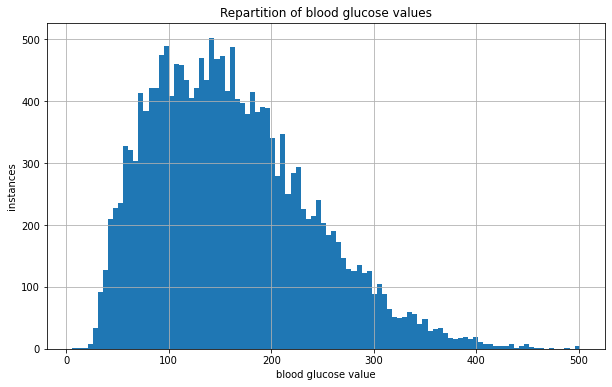

In [36]:
# plot repatition of blood glucose values
plt.figure(figsize=(10, 6))
data['glucose'].hist(bins=100)
plt.xlabel('blood glucose value')
plt.ylabel('instances')
plt.title('Repartition of blood glucose values')

<h1>Imputing values / dealing with NaNs </h1>

There are a lot missing values in the glucose column (about 26%), cannot just be erased from the dataframe.
NaNs cannot be used in the model.

In [20]:
from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = imp.fit(X_train)

# Impute our data, then train
#X_train_imp = imp.transform(X_train)

#data['glucose'] = data['glucose'].interpolate(method='polynomial', order=3) #order 2 & 3 gives out negative glucose values
data['glucose'] = data['glucose'].interpolate(method='linear')
#data['glucose'] = data['glucose'].interpolate(key='timestamp', method='time')
data.head()

,timestamp,time,cleaned_code,code_glucose,glucose,code_insulin,insulin,hypo_symptoms,code_meal,meal,other,code_exercise,exercise
0,1991-04-21 09:09:00,549,34,58.0,100.0,34.0,9,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-04-21 17:08:00,1028,33,62.0,119.0,33.0,7,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-04-21 22:51:00,1371,57,48.0,123.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-04-22 07:35:00,455,34,58.0,216.0,34.0,10,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-04-22 13:40:00,820,33,0.0,213.5,33.0,2,0.0,0.0,0.0,0.0,0.0,0.0


Ways to deal with missing values. <br>
<ul>
    <li>polynomial interpolation --> 2nd and 3rd degree give out some negative glucose values --> unrealistic</li>
    <li>linear interpolation</li>
</ul>

In [21]:
print(missing_cols(data))
print(perc_missing(data))

no missing values left
None
None


<h1>Data splitting </h1>

In [22]:
data = data.dropna()

#X = data[['time', 'cleaned_code']]
y = data['glucose']

# Assign feature variables
X1 = data.time
X2 = pd.get_dummies(data.cleaned_code)
# Drop unspecified to avoid collinearity (Dummy trap)
#X2 = X2.drop(columns = 'Unspecified measurement')
# Merge time and  code into one array
X = np.c_[X1, X2]


In [23]:
# train-test splitting of data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=1)

<h1>Model</h1>

In [24]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators = 100, random_state = 1)

# Fitting the Random Forest Regression model to the data
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

<h1>Model evaluation </h1>

In [46]:
# Predicting the target values of the test set
y_pred = regr.predict(X_test)

#r² score
from sklearn.metrics import r2_score
print("r² score: ", format(r2_score(y_test, y_pred), '.3f'))
#print(r2_score(X_train, y_train))
#print(r2_score(X_test, y_test))
#print(regr.score(y_test, y_pred))

# MSE (means squared error) & RMSE (Root Mean Square Error)
from sklearn.metrics import mean_squared_error
print("MSE: ", format(mean_squared_error(y_test, y_pred),'.3f'))
print("RMSE: ", format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))

#MAE (Mean Absolute Error)
from sklearn.metrics import mean_absolute_error
print("MAE: ", format(mean_absolute_error(y_test, y_pred), '.3f'))

r² score:  -0.050
MSE:  6216.131
RMSE:  78.842
MAE:  61.192


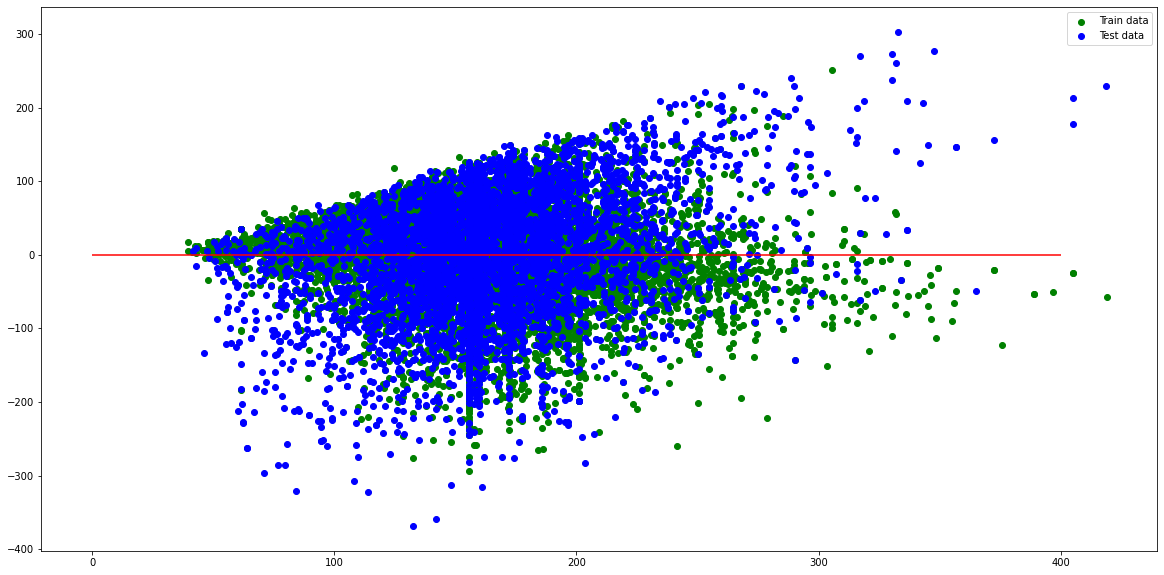

In [32]:
plt.figure(figsize=(20, 10))
# Scatter plot for training data
plt.scatter(regr.predict(X_train), regr.predict(X_train) - y_train, 
            color = "green", label = 'Train data') 
 
# plot predicted data
plt.plot(regr.predict(X_test), regr.predict(X_test) - y_test,
            'o',color = "blue", label = 'Test data') 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 400,color = "red")
plt.legend()

Text(0.5, 0, 'blood glucose level')

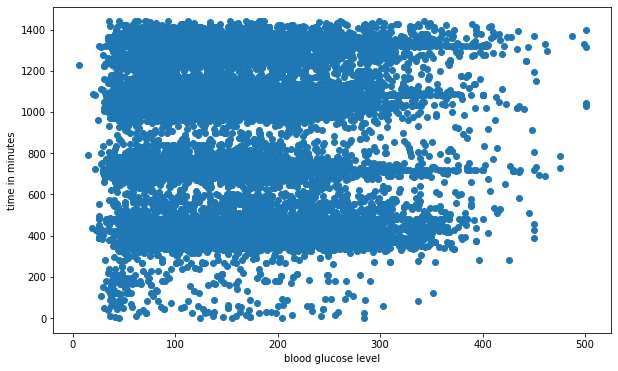

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(data['glucose'], data['time'])
plt.ylabel("time in minutes")
plt.xlabel("blood glucose level")

Text(0.5, 0, 'blood glucose level')

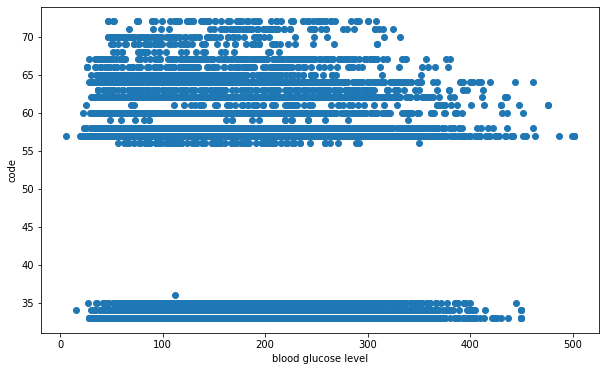

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(data['glucose'], data['cleaned_code'])
plt.ylabel("code")
plt.xlabel("blood glucose level")

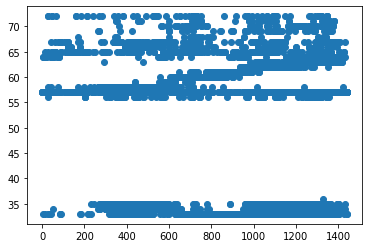

In [28]:
plt.scatter(data['time'], data['cleaned_code'])

In [29]:
data[data.glucose < 0]

,timestamp,time,cleaned_code,code_glucose,glucose,code_insulin,insulin,hypo_symptoms,code_meal,meal,other,code_exercise,exercise
